Since we choose the random forest model, I will further finetune it by using Grid Search for a comprehensive search for the best parameter. As Grid Search use 5 splits internally [[1]](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), we will remove KFold from our model since we used 4 splits for models benchmarking

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [2]:
df_train = pd.read_csv("../data/transformed_train.csv")
df_test = pd.read_csv("../data/transformed_test.csv")

# Separate our features and target 
df_X = df_train.drop(["Status"], axis=1)
df_y = df_train[["Status"]]

# Splitting our training data into a train set and a validation set
train_X, val_X, train_y, val_y = train_test_split(
    df_X, df_y,
    shuffle=True, 
    test_size=0.2,
    random_state=0
)


In [3]:
params = {
    "n_estimators": np.arange(5, 25, 5),
    "max_depth": np.arange(2, 24, 2),
}

clf = RandomForestClassifier(
    criterion="gini",  
    class_weight="balanced",
    random_state=0   
)

trees_clf = GridSearchCV(
    clf,
    params,
    scoring=["f1", "roc_auc"], refit="f1",
    return_train_score=True,
    n_jobs=-2
)
trees_clf.fit(train_X, train_y.to_numpy().ravel())

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=0),
             n_jobs=-2,
             param_grid={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22]),
                         'n_estimators': array([ 5, 10, 15, 20])},
             refit='f1', return_train_score=True, scoring=['f1', 'roc_auc'])

In [4]:
trees_clf.best_params_

{'max_depth': 22, 'n_estimators': 20}

In [5]:
train_pred_y = trees_clf.predict(train_X)
val_pred_y = trees_clf.predict(val_X)

final_train_performance_report = classification_report(train_y, train_pred_y)
final_val_performance_report = classification_report(val_y, val_pred_y)

print(f"Training performance\n{final_train_performance_report}")
print(f"Validation performance\n{final_val_performance_report}")

Training performance
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    133766
           1       1.00      1.00      1.00    133934

    accuracy                           1.00    267700
   macro avg       1.00      1.00      1.00    267700
weighted avg       1.00      1.00      1.00    267700

Validation performance
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     33547
           1       0.98      0.99      0.98     33379

    accuracy                           0.98     66926
   macro avg       0.99      0.98      0.98     66926
weighted avg       0.99      0.98      0.98     66926



As our dataset is quite large, I will not use graphviz to display information of each leaf

[Text(0.42117044388015124, 0.9782608695652174, 'ExtraMedTest <= 0.521\ngini = 0.5\nsamples = 169256\nvalue = [134228.237, 133472.237]\nclass = HighBP'),
 Text(0.20261082552297963, 0.9347826086956522, 'BMI <= 0.607\ngini = 0.244\nsamples = 74195\nvalue = [100733.217, 16690.526]\nclass = HighBP'),
 Text(0.1130749980740962, 0.8913043478260869, 'BMI <= 0.464\ngini = 0.19\nsamples = 53180\nvalue = [75269.237, 8954.381]\nclass = HighBP'),
 Text(0.04965922577250892, 0.8478260869565217, 'Fruits <= 0.5\ngini = 0.161\nsamples = 32528\nvalue = [46990.49, 4537.153]\nclass = HighBP'),
 Text(0.015838010394973144, 0.8043478260869565, 'ExtraAlcoholTest <= 0.782\ngini = 0.173\nsamples = 10497\nvalue = [14981.402, 1587.004]\nclass = HighBP'),
 Text(0.015770558475544462, 0.7608695652173914, 'ExtraAlcoholTest <= 0.521\ngini = 0.093\nsamples = 9964\nvalue = [14981.402, 767.518]\nclass = HighBP'),
 Text(0.006114279360555804, 0.717391304347826, 'GenHlth <= 0.429\ngini = 0.027\nsamples = 7266\nvalue = [11290.

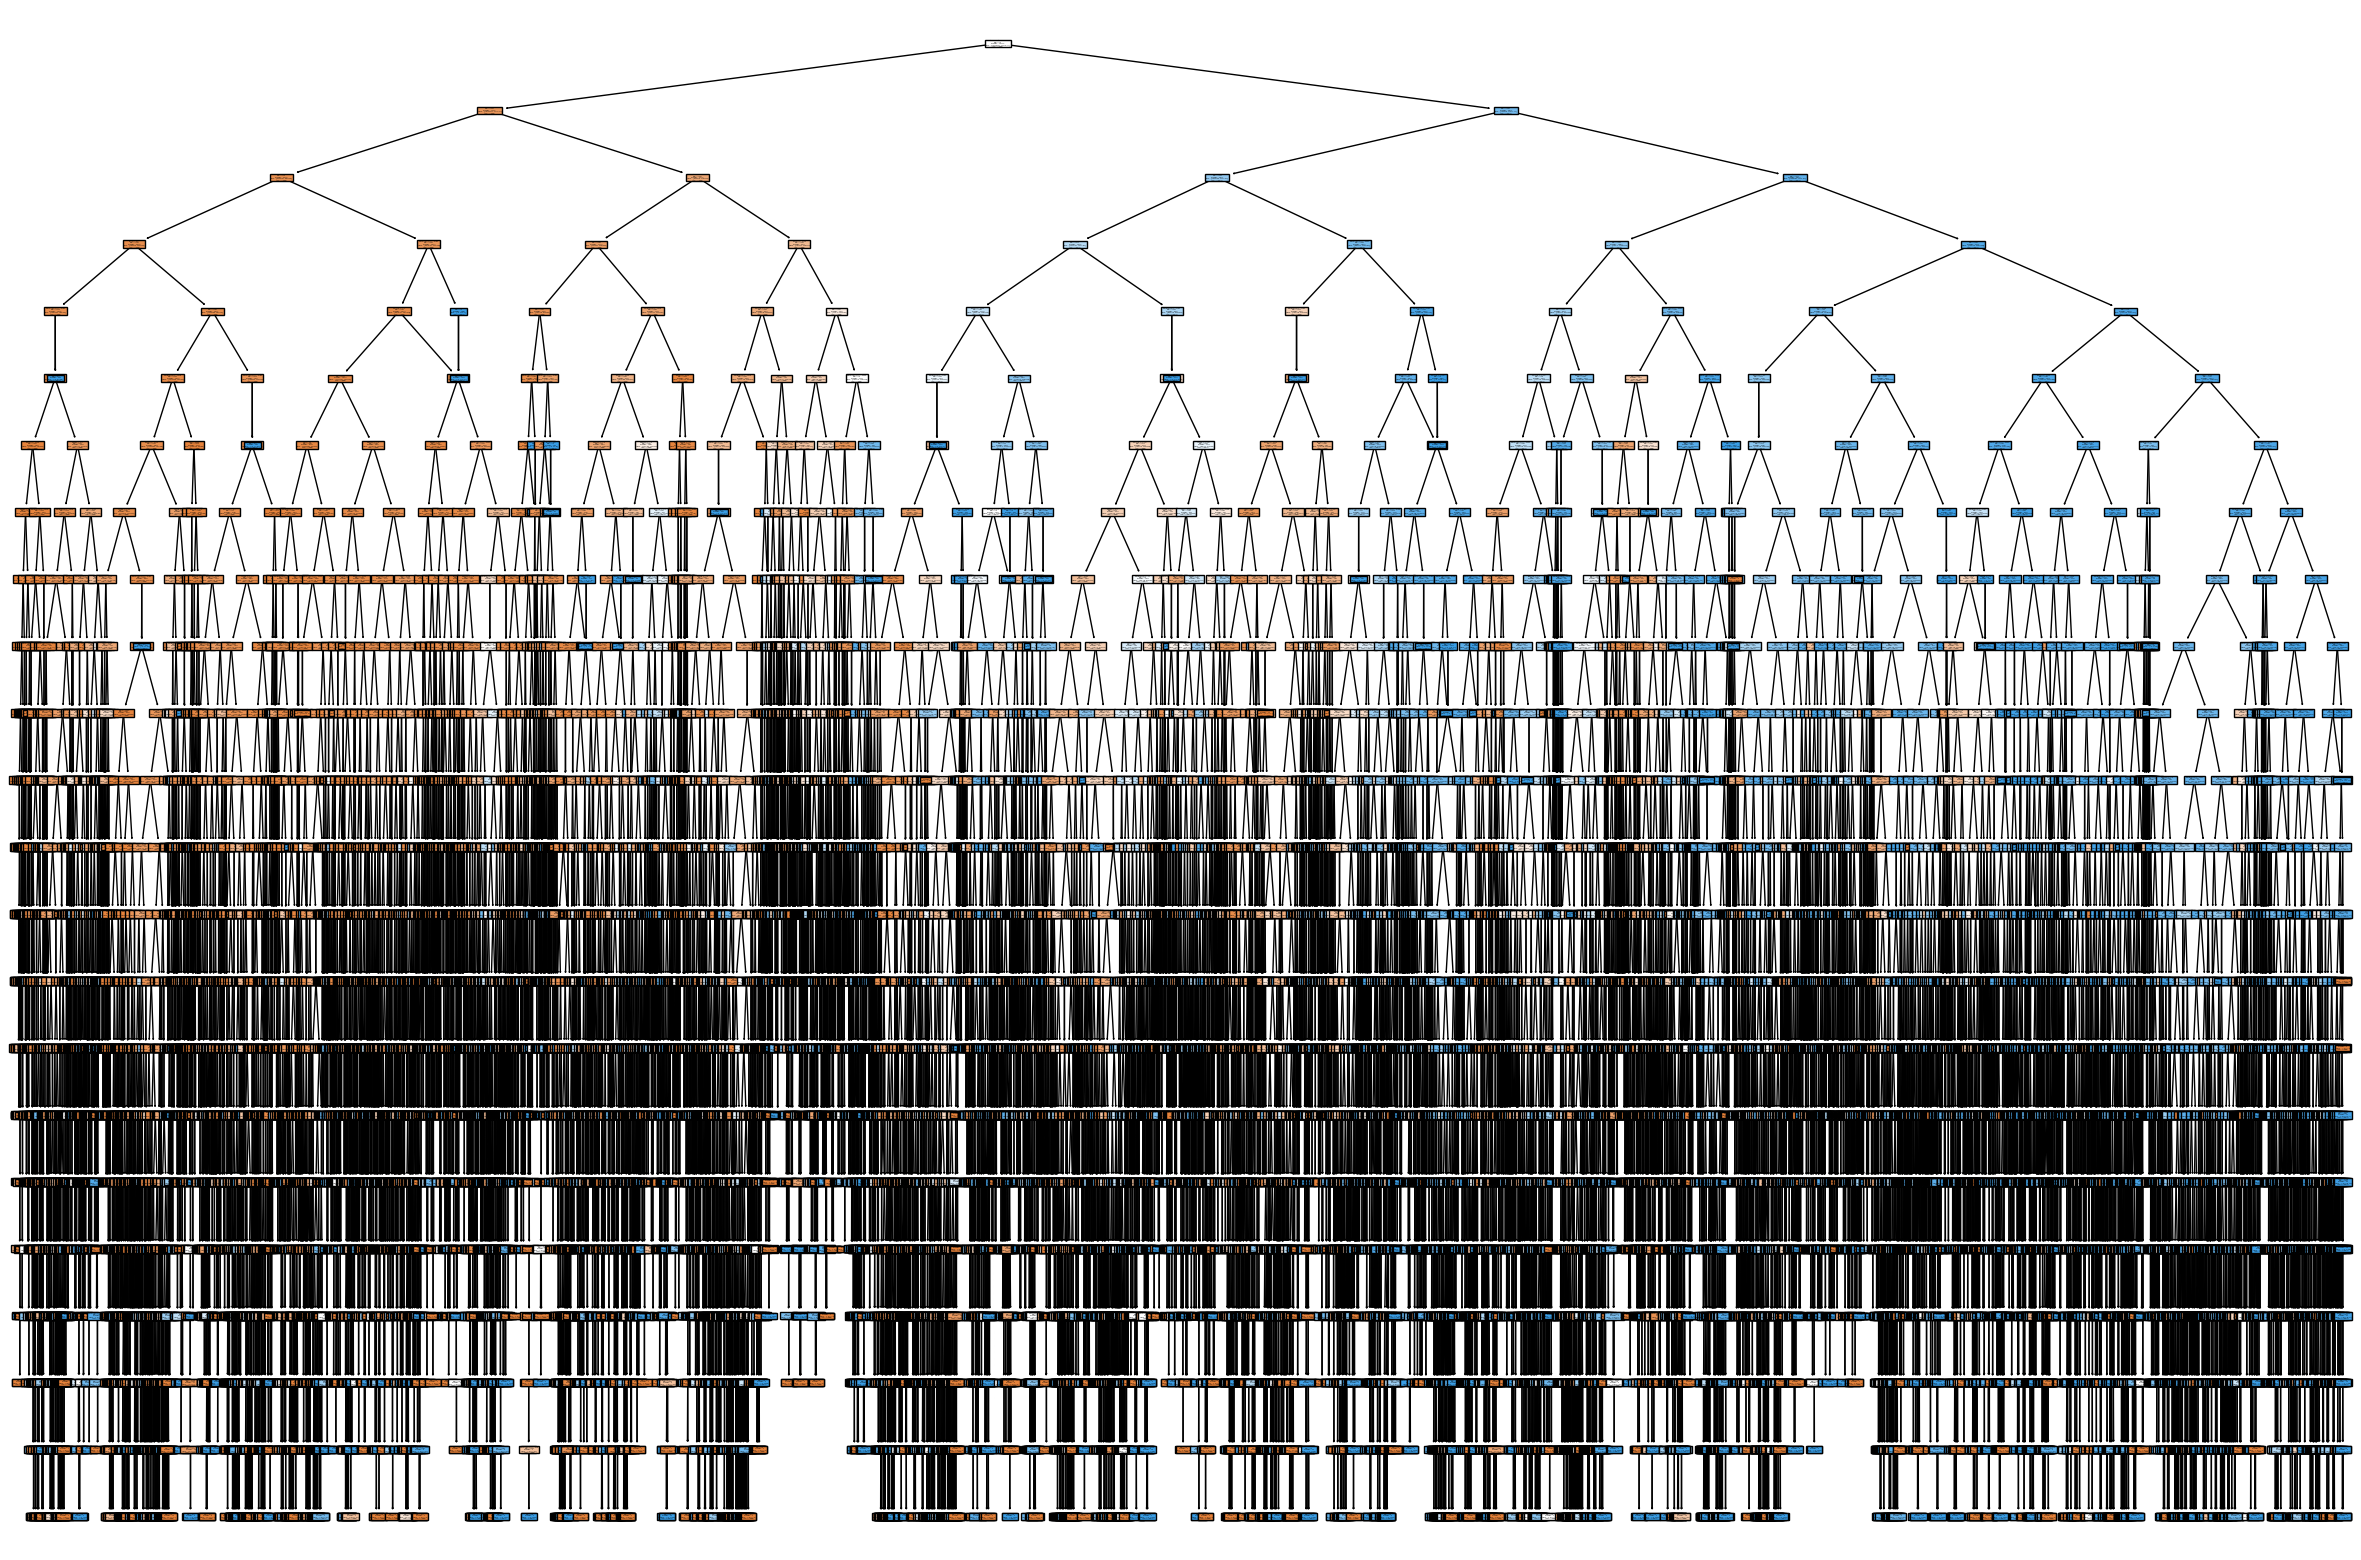

In [7]:
plt.subplots(figsize=(30,20))
decision_tree = trees_clf.best_estimator_.estimators_[0]
tree.plot_tree(
    decision_tree,
    feature_names=df_X.columns,
    class_names=df_X.columns,
    filled=True
)

Feature importances

In [8]:
feature_importances = pd.DataFrame(trees_clf.best_estimator_.feature_importances_, index = df_X.columns, columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,importance
ExtraMedTest,0.414146
ExtraAlcoholTest,0.346672
BMI,0.046273
GenHlth,0.033780
Age,0.032866
HighBP,0.029934
Income,0.024002
PhysHlth,0.016166
Education,0.015086
HighChol,0.010986


# Prediction

In [9]:
df_test_original = pd.read_csv("../data/data_test.csv")
patient_id = df_test_original["Id"].values

pred_y = trees_clf.predict(df_test)

df_export = pd.DataFrame({"Id": patient_id, "Status": pred_y})

In [10]:
df_export.head()

,Id,Status
0,202944,0
1,202945,0
2,202946,0
3,202947,0
4,202948,0


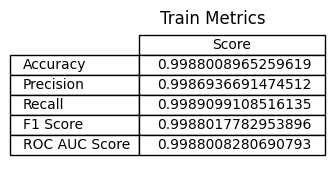

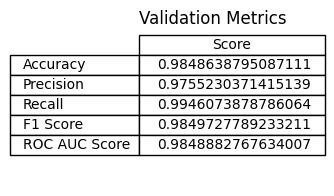

In [21]:
def metrics(y_true, y_pred, title, save_path=None):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    # Create a DataFrame for the metrics
    metrics_data = {
        'Metrics': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC Score'],
        'Score': [[accuracy], [precision], [recall], [f1], [roc_auc]]
    }

    # Create a figure and axis with a smaller size
    fig, ax = plt.subplots(figsize=(2, 2))

    # Hide axes
    ax.axis('tight')
    ax.axis('off')

    # Create table and display it
    table = ax.table(cellText=metrics_data['Score'],
             rowLabels=metrics_data['Metrics'],
             colLabels=['Score'],
             cellLoc = 'left',  # Align the text to the left
             loc='upper left')  # Position the table at the upper left corner

    # Set the font size, scale the table, and add a title
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2) 
    ax.set_title(title)

    if save_path:
        plt.savefig(save_path)

    plt.show()

metrics(train_y, train_pred_y, title='Train Metrics', save_path="../images/train_random_forest_metrics.png")
metrics(val_y, val_pred_y, title='Validation Metrics', save_path="../images/val_random_forest_metrics.png")

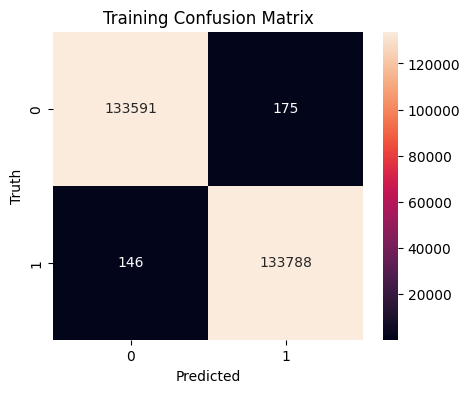

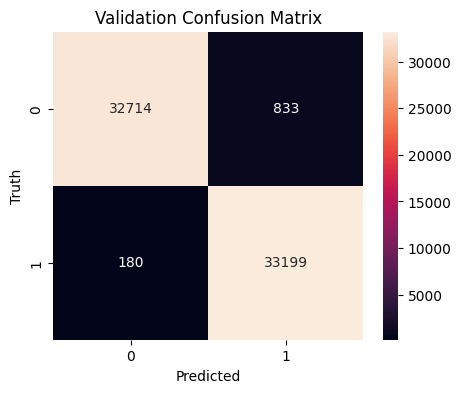

In [29]:
# Confusion matrix
train_conf_matrix = confusion_matrix(train_y, train_pred_y)
val_conf_matrix = confusion_matrix(val_y, val_pred_y)

# Plot training confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(train_conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Training Confusion Matrix')
plt.savefig("../images/train_random_forest_confusion_matrix.png")
plt.show()

# Plot validation confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(val_conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Validation Confusion Matrix')
plt.savefig("../images/val_random_forest_confusion_matrix.png")
plt.show()

In [13]:
export_path = "../data/result/s3925921_predictions.csv"
df_export.to_csv(export_path, index=False)